# MTH 4320/5320 Python Quiz

## Problem 1

Consider the hyperbolic tangent activation function.

$$f(w_0, w_1, x_1, w_2, x_2) = \tanh(w_0 + w_1x_1 + w_2x_2)$$

### Parts (a)-(b)

Draw a computational graph for a neuron with hyperbolic tangent activation.

Compute the gradient when $(w_0, w_1, x_1, w_2, x_2) = (2, 2, −1, 0, −4)$ by feeding the point forward and backpropagating the error along the computational graph.

### Part (c)

Compute the gradient by the chain rule.

$f_{w_0}(w_0, w_1, x_1, w_2, x_2) = \text{sech}^2(w_0 + w_1x_1 + w_2x_2)$

$f_{w_1}(w_0, w_1, x_1, w_2, x_2) = \text{sech}^2(w_0 + w_1x_1 + w_2x_2)x_1$

$f_{x_1}(w_0, w_1, x_1, w_2, x_2) = \text{sech}^2(w_0 + w_1x_1 + w_2x_2)w_1$

$f_{w_2}(w_0, w_1, x_1, w_2, x_2) = \text{sech}^2(w_0 + w_1x_1 + w_2x_2)x_2$

$f_{x_2}(w_0, w_1, x_1, w_2, x_2) = \text{sech}^2(w_0 + w_1x_1 + w_2x_2)w_2$

Therefore,

$\nabla f(w_0, w_1, x_1, w_2, x_2) = \text{sech}^2(w_0 + w_1x_1 + w_2x_2)(1, x_1, w_1, x_2, w_2)$

## Problem 2

Add options to choose between several activation functions: sigmoid, hyperbolic tangent, and rectified linear unit (ReLU) to the fully-connected feedforward neural net Python class with SGD.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import to_categorical

In [2]:
# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   annealing - a list specifying the annealing schedule for the learning rate
#     'none' - use a constant learning rate
#     ['step', k] - decay the learning rate to 0 at k evenly spaced times with identical steps
#     ['exp', k] - decay the learning rate exponentially alpha = alpha0(exp(-k*epoch))
#     ['inv', k] - decay the learning rate as alpha = alpha0/(1 + k*epoch)
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#     'tanh' - hyperbolic tangent function
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, annealing = 'none', lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # annealing policy
        self.annealing = annealing
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
        
        if self.activation == 'tanh':
            return np.tanh(x)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
        
        if self.activation == 'tanh':
            return 1 - self.activate(x) ** 2
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, valX, valY, epochs = 10000, update = 1000, printPerformance = True):
        
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        valX = np.hstack((valX, np.ones([valX.shape[0],1])))
        losses = []
        validationLosses = []
        trainAccuracies = []
        validationAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the labels
        y = to_categorical(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))
            
        alpha = self.alpha

        for epoch in np.arange(0,epochs):
            
            if self.annealing[0] == 'step':
                stepSize = self.alpha/self.annealing[1]
                if epochs > 0 and epoch % self.annealing[1] == 0:
                    alpha -= stepSize
                    print(alpha)
                
            elif self.annealing[0] == 'exp':
                alpha = self.alpha * np.exp(-self.annealing[1] * epoch)
                    
            elif self.annealing[0] == 'inv':
                alpha = self.alpha / (1 + self.annealing[1] * epoch)
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                
                # make a list of output activations from the first layer
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply the activation
                    net = A[layer] @ self.W[layer]
                    
                    if layer == len(self.W) - 1:
                        out = 1/(1 + np.exp(-net))
                    else:
                        out = self.activate(net)
                    
                    # add pre-activations Z and activations A of the current layer
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1] @ self.W[layer].T
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T @ D[layer]
                                + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer])
                                + (self.lambda2 / numberOfExamples) * self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + alpha * gradient
                    self.W[layer] -= v[layer]
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:        

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)
                    
                    predictedY = self.predict(valX, addOnes = False)
                    predictedY = predictedY.argmax(axis=1)
                    validationAccuracy = accuracy_score(valY, predictedY)

                    validationAccuracies.append(validationAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    
                    loss = self.computeLoss(X,y)
                    losses.append(loss)
                    
                    validationLoss = self.computeLoss(valX, to_categorical(valY))
                    validationLosses.append(validationLoss)
                    print("[INFO] epoch = {}, loss = {:.3f}, validation loss = {:.3f} training accuracy = {:.3f}, validation accuracy = {:.3f}".format(epoch + 1, loss, validationLoss, trainAccuracy, validationAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))
                    print('[INFO] Epoch =', epoch + 1, 'of', epochs)

        # if we chose to print the performance, plot loss, training accuracy, and validation accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss (train)', color = 'black')
            p2 = ax1.plot(np.arange(0, epochs, update), validationLosses, label = 'Loss (validation)', color = 'blue')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p3 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'orange')
            p4 = ax2.plot(np.arange(0, epochs, update), validationAccuracies, label = 'Accuracy (validation)', color = 'green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3 + p4
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            if layer == len(self.W) - 1:
                p = 1/(1 + np.exp(-p @ self.W[layer]))
            else:
                p = self.activate(p @ self.W[layer])
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

## Problem 3

Apply a fully-connected feedforward neural network (with SGD) to the problem of classifying the MNIST dataset and compute validation accuracy at each training epoch.

Generate two plots: (1) training epoch number vs. training and validation loss and (2) training epoch number vs. training and validation accuracy.

[INFO] epoch = 1, loss = 0.525, validation loss = 0.545 training accuracy = 0.920, validation accuracy = 0.917
[INFO] epoch = 2, loss = 0.518, validation loss = 0.545 training accuracy = 0.922, validation accuracy = 0.917
[INFO] epoch = 3, loss = 0.461, validation loss = 0.495 training accuracy = 0.931, validation accuracy = 0.926
[INFO] epoch = 4, loss = 0.392, validation loss = 0.419 training accuracy = 0.941, validation accuracy = 0.936
[INFO] epoch = 5, loss = 0.378, validation loss = 0.411 training accuracy = 0.945, validation accuracy = 0.939
[INFO] epoch = 6, loss = 0.357, validation loss = 0.408 training accuracy = 0.946, validation accuracy = 0.941
[INFO] epoch = 7, loss = 0.368, validation loss = 0.443 training accuracy = 0.944, validation accuracy = 0.933
[INFO] epoch = 8, loss = 0.371, validation loss = 0.413 training accuracy = 0.943, validation accuracy = 0.938
[INFO] epoch = 9, loss = 0.374, validation loss = 0.447 training accuracy = 0.943, validation accuracy = 0.938
[

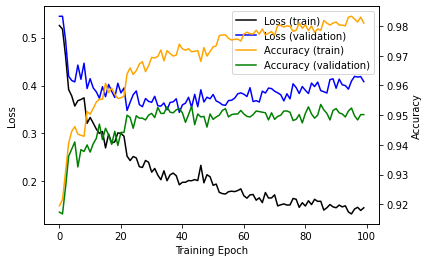

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist

# load mnist data
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX/255.0
testX = testX/255.0

# reshape the data to a vector
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# split test data into validation and test sets
valX, testX, valY, testY = train_test_split(testX, testY, test_size = 0.5)

# create a model
model = FeedforwardNeuralNetwork([784, 32, 10], 0.1, initialization = ['Glorot', 'normal'], loss = 'cross-entropy')

# fit the model to the training data
model.fit(trainX, trainY, valX, valY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

## Problem 4

Train models on MNIST with each choice of activation to see if there are differences in classification performance or computational time. Generate the same plots as \#3

[INFO] epoch = 1, loss = 0.619, validation loss = 0.604 training accuracy = 0.913, validation accuracy = 0.914
[INFO] epoch = 2, loss = 0.503, validation loss = 0.510 training accuracy = 0.930, validation accuracy = 0.928
[INFO] epoch = 3, loss = 0.440, validation loss = 0.449 training accuracy = 0.938, validation accuracy = 0.935
[INFO] epoch = 4, loss = 0.393, validation loss = 0.412 training accuracy = 0.945, validation accuracy = 0.940
[INFO] epoch = 5, loss = 0.375, validation loss = 0.396 training accuracy = 0.947, validation accuracy = 0.944
[INFO] epoch = 6, loss = 0.343, validation loss = 0.368 training accuracy = 0.953, validation accuracy = 0.947
[INFO] epoch = 7, loss = 0.331, validation loss = 0.356 training accuracy = 0.956, validation accuracy = 0.948
[INFO] epoch = 8, loss = 0.307, validation loss = 0.339 training accuracy = 0.959, validation accuracy = 0.952
[INFO] epoch = 9, loss = 0.297, validation loss = 0.331 training accuracy = 0.961, validation accuracy = 0.955
[

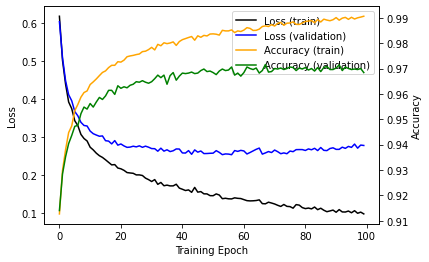

In [4]:
# load mnist data
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX/255.0
testX = testX/255.0

# reshape the data to a vector
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# split test data into validation and test sets
valX, testX, valY, testY = train_test_split(testX, testY, test_size = 0.5)

# create a model
model = FeedforwardNeuralNetwork([784, 32, 10], 0.001, activations = 'ReLU', initialization = ['Glorot', 'normal'], loss = 'cross-entropy')

# fit the model to the training data
model.fit(trainX, trainY, valX, valY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

[INFO] epoch = 1, loss = 11.456, validation loss = 11.240 training accuracy = 0.281, validation accuracy = 0.283
[INFO] epoch = 2, loss = 15.873, validation loss = 15.545 training accuracy = 0.374, validation accuracy = 0.382
[INFO] epoch = 3, loss = 20.785, validation loss = 20.280 training accuracy = 0.251, validation accuracy = 0.258
[INFO] epoch = 4, loss = 15.351, validation loss = 15.182 training accuracy = 0.356, validation accuracy = 0.354
[INFO] epoch = 5, loss = 9.290, validation loss = 9.054 training accuracy = 0.374, validation accuracy = 0.389
[INFO] epoch = 6, loss = 14.417, validation loss = 14.514 training accuracy = 0.255, validation accuracy = 0.243
[INFO] epoch = 7, loss = 17.094, validation loss = 16.962 training accuracy = 0.355, validation accuracy = 0.351
[INFO] epoch = 8, loss = 13.079, validation loss = 12.747 training accuracy = 0.366, validation accuracy = 0.368
[INFO] epoch = 9, loss = 6.224, validation loss = 6.330 training accuracy = 0.537, validation accu

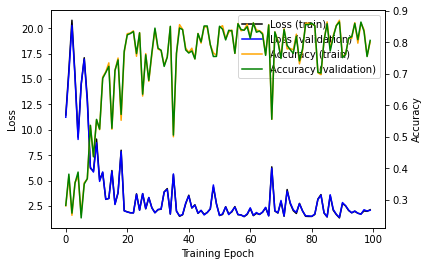

In [5]:
# load mnist data
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX/255.0
testX = testX/255.0

# reshape the data to a vector
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# split test data into validation and test sets
valX, testX, valY, testY = train_test_split(testX, testY, test_size = 0.5)

# create a model
model = FeedforwardNeuralNetwork([784, 32, 10], 0.1, activations = 'tanh', initialization = ['Glorot', 'normal'], loss = 'cross-entropy')

# fit the model to the training data
model.fit(trainX, trainY, valX, valY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

## Problem 5

Select the best activation from \#4 and, based on the plots, decide if a larger network or a smaller network is likely to work better and explain your reasoning.

There is very little overfitting, but about 4\% training images are not learned, so I will try larger models.

## Problem 6

Depending on your answer from \#5, train and test the model for at least 3 neural architectures that are larger or smaller.

We will do:

* One with a larger hidden layer: 64 neurons
* One with a second hidden layer: 16 neurons
* One with both: 64 and 32 neurons

[INFO] epoch = 1, loss = 0.565, validation loss = 0.553 training accuracy = 0.920, validation accuracy = 0.920
[INFO] epoch = 2, loss = 0.433, validation loss = 0.437 training accuracy = 0.939, validation accuracy = 0.934
[INFO] epoch = 3, loss = 0.359, validation loss = 0.368 training accuracy = 0.950, validation accuracy = 0.947
[INFO] epoch = 4, loss = 0.317, validation loss = 0.334 training accuracy = 0.956, validation accuracy = 0.951
[INFO] epoch = 5, loss = 0.282, validation loss = 0.304 training accuracy = 0.962, validation accuracy = 0.955
[INFO] epoch = 6, loss = 0.258, validation loss = 0.279 training accuracy = 0.965, validation accuracy = 0.957
[INFO] epoch = 7, loss = 0.235, validation loss = 0.270 training accuracy = 0.969, validation accuracy = 0.959
[INFO] epoch = 8, loss = 0.220, validation loss = 0.257 training accuracy = 0.971, validation accuracy = 0.962
[INFO] epoch = 9, loss = 0.205, validation loss = 0.245 training accuracy = 0.973, validation accuracy = 0.964
[

C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 79, loss = nan, validation loss = 0.233 training accuracy = 0.999, validation accuracy = 0.976
[INFO] epoch = 80, loss = 0.031, validation loss = 0.229 training accuracy = 0.999, validation accuracy = 0.978
[INFO] epoch = 81, loss = 0.031, validation loss = 0.233 training accuracy = 0.999, validation accuracy = 0.976
[INFO] epoch = 82, loss = 0.030, validation loss = 0.227 training accuracy = 0.999, validation accuracy = 0.977
[INFO] epoch = 83, loss = 0.029, validation loss = 0.232 training accuracy = 0.999, validation accuracy = 0.977
[INFO] epoch = 84, loss = 0.032, validation loss = 0.236 training accuracy = 0.999, validation accuracy = 0.976
[INFO] epoch = 85, loss = 0.029, validation loss = 0.234 training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 86, loss = nan, validation loss = 0.236 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 87, loss = nan, validation loss = 0.235 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 88, loss = nan, validation loss = 0.238 training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 89, loss = nan, validation loss = 0.237 training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 90, loss = nan, validation loss = 0.243 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 91, loss = nan, validation loss = 0.241 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 92, loss = nan, validation loss = 0.239 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 93, loss = nan, validation loss = 0.242 training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 94, loss = nan, validation loss = 0.242 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 95, loss = nan, validation loss = 0.243 training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 96, loss = nan, validation loss = 0.244 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 97, loss = nan, validation loss = 0.249 training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 98, loss = nan, validation loss = 0.243 training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 99, loss = nan, validation loss = 0.243 training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 100, loss = nan, validation loss = 0.247 training accuracy = 0.999, validation accuracy = 0.976
Test set accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       488
           1       0.99      0.99      0.99       565
           2       0.99      0.97      0.98       521
           3       0.98      0.98      0.98       500
           4       0.97      0.97      0.97       473
           5       0.98      0.97      0.98       442
           6       0.97      0.98      0.97       473
           7       0.98      0.98      0.98       525
           8       0.97      0.98      0.97       510
           9       0.97      0.97      0.97       503

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



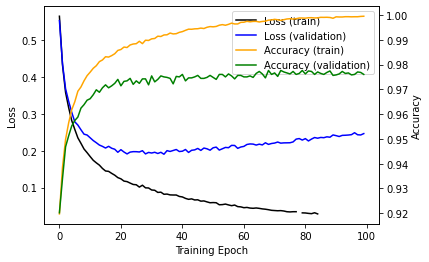

In [6]:
# load mnist data
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX/255.0
testX = testX/255.0

# reshape the data to a vector
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# split test data into validation and test sets
valX, testX, valY, testY = train_test_split(testX, testY, test_size = 0.5)

# create a model
model = FeedforwardNeuralNetwork([784, 64, 10], 0.001, activations = 'ReLU', initialization = ['Glorot', 'normal'], loss = 'cross-entropy')

# fit the model to the training data
model.fit(trainX, trainY, valX, valY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

[INFO] epoch = 1, loss = 0.492, validation loss = 0.494 training accuracy = 0.928, validation accuracy = 0.926
[INFO] epoch = 2, loss = 0.370, validation loss = 0.367 training accuracy = 0.946, validation accuracy = 0.943
[INFO] epoch = 3, loss = 0.314, validation loss = 0.330 training accuracy = 0.953, validation accuracy = 0.948
[INFO] epoch = 4, loss = 0.272, validation loss = 0.292 training accuracy = 0.962, validation accuracy = 0.958
[INFO] epoch = 5, loss = 0.243, validation loss = 0.272 training accuracy = 0.966, validation accuracy = 0.962
[INFO] epoch = 6, loss = 0.221, validation loss = 0.255 training accuracy = 0.970, validation accuracy = 0.964
[INFO] epoch = 7, loss = 0.198, validation loss = 0.234 training accuracy = 0.973, validation accuracy = 0.968
[INFO] epoch = 8, loss = 0.206, validation loss = 0.247 training accuracy = 0.971, validation accuracy = 0.965
[INFO] epoch = 9, loss = 0.182, validation loss = 0.234 training accuracy = 0.976, validation accuracy = 0.967
[

C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 31, loss = nan, validation loss = 0.239 training accuracy = 0.990, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 32, loss = nan, validation loss = 0.243 training accuracy = 0.989, validation accuracy = 0.971


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 33, loss = nan, validation loss = 0.244 training accuracy = 0.989, validation accuracy = 0.969


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 34, loss = nan, validation loss = 0.244 training accuracy = 0.991, validation accuracy = 0.970


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 35, loss = nan, validation loss = 0.241 training accuracy = 0.990, validation accuracy = 0.970


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 36, loss = nan, validation loss = 0.239 training accuracy = 0.991, validation accuracy = 0.969


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 37, loss = nan, validation loss = 0.249 training accuracy = 0.992, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 38, loss = nan, validation loss = nan training accuracy = 0.990, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 39, loss = nan, validation loss = nan training accuracy = 0.990, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 40, loss = nan, validation loss = nan training accuracy = 0.992, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 41, loss = nan, validation loss = nan training accuracy = 0.992, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 42, loss = nan, validation loss = nan training accuracy = 0.991, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 43, loss = nan, validation loss = nan training accuracy = 0.993, validation accuracy = 0.969


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 44, loss = nan, validation loss = nan training accuracy = 0.993, validation accuracy = 0.970


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 45, loss = nan, validation loss = 0.263 training accuracy = 0.993, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 46, loss = nan, validation loss = nan training accuracy = 0.994, validation accuracy = 0.970


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 47, loss = nan, validation loss = nan training accuracy = 0.994, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 48, loss = nan, validation loss = nan training accuracy = 0.994, validation accuracy = 0.969


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 49, loss = nan, validation loss = nan training accuracy = 0.992, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 50, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 51, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.970


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 52, loss = nan, validation loss = nan training accuracy = 0.993, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 53, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 54, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 55, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 56, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 57, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 58, loss = nan, validation loss = nan training accuracy = 0.994, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 59, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 60, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.964


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 61, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 62, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 63, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 64, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.965


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 65, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 66, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 67, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 68, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.969


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 69, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.964


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 70, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 71, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 72, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 73, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 74, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 75, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 76, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 77, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.964


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 78, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.965


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 79, loss = nan, validation loss = nan training accuracy = 0.995, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 80, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.968


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 81, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 82, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.965


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 83, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 84, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 85, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 86, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 87, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 88, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 89, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 90, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 91, loss = nan, validation loss = nan training accuracy = 0.997, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 92, loss = nan, validation loss = nan training accuracy = 0.996, validation accuracy = 0.964


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 93, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 94, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.969


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 95, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.965


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 96, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.965


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 97, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.967


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 98, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 99, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.966


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 100, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.966
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       481
           1       0.99      0.99      0.99       585
           2       0.98      0.95      0.96       500
           3       0.94      0.98      0.96       505
           4       0.96      0.96      0.96       485
           5       0.97      0.95      0.96       473
           6       0.97      0.96      0.97       481
           7       0.97      0.96      0.96       515
           8       0.97      0.96      0.96       477
           9       0.96      0.96      0.96       498

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



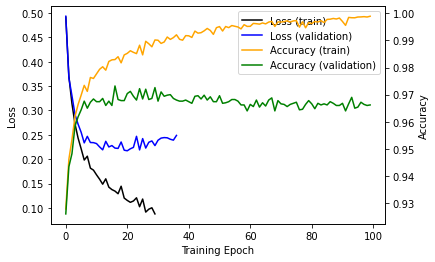

In [7]:
# load mnist data
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX/255.0
testX = testX/255.0

# reshape the data to a vector
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# split test data into validation and test sets
valX, testX, valY, testY = train_test_split(testX, testY, test_size = 0.5)

# create a model
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.001, activations = 'ReLU', initialization = ['Glorot', 'normal'], loss = 'cross-entropy')

# fit the model to the training data
model.fit(trainX, trainY, valX, valY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

[INFO] epoch = 1, loss = 0.449, validation loss = 0.455 training accuracy = 0.935, validation accuracy = 0.934
[INFO] epoch = 2, loss = 0.318, validation loss = 0.343 training accuracy = 0.954, validation accuracy = 0.947
[INFO] epoch = 3, loss = 0.293, validation loss = 0.325 training accuracy = 0.958, validation accuracy = 0.949
[INFO] epoch = 4, loss = 0.221, validation loss = 0.260 training accuracy = 0.969, validation accuracy = 0.961
[INFO] epoch = 5, loss = 0.189, validation loss = 0.238 training accuracy = 0.974, validation accuracy = 0.964
[INFO] epoch = 6, loss = 0.166, validation loss = 0.224 training accuracy = 0.978, validation accuracy = 0.964
[INFO] epoch = 7, loss = 0.148, validation loss = 0.213 training accuracy = 0.980, validation accuracy = 0.968
[INFO] epoch = 8, loss = 0.141, validation loss = 0.210 training accuracy = 0.982, validation accuracy = 0.968
[INFO] epoch = 9, loss = 0.121, validation loss = 0.203 training accuracy = 0.985, validation accuracy = 0.966
[

C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 25, loss = nan, validation loss = 0.190 training accuracy = 0.996, validation accuracy = 0.975


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 26, loss = nan, validation loss = 0.195 training accuracy = 0.998, validation accuracy = 0.975
[INFO] epoch = 27, loss = 0.035, validation loss = 0.189 training accuracy = 0.997, validation accuracy = 0.975


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 28, loss = nan, validation loss = 0.188 training accuracy = 0.998, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 29, loss = nan, validation loss = 0.185 training accuracy = 0.998, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 30, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 31, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 32, loss = nan, validation loss = nan training accuracy = 0.998, validation accuracy = 0.975


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 33, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 34, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 35, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 36, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 37, loss = nan, validation loss = nan training accuracy = 0.999, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 38, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 39, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 40, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 41, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 42, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 43, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 44, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 45, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 46, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 47, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 48, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 49, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 50, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 51, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 52, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 53, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 54, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 55, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 56, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 57, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.976


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 58, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 59, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 60, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 61, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 62, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 63, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 64, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 65, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 66, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 67, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 68, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 69, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 70, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 71, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 72, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 73, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 74, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 75, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 76, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 77, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 78, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 79, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 80, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 81, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 82, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 83, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 84, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 85, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 86, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 87, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 88, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 89, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 90, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 91, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 92, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 93, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 94, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 95, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 96, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 97, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 98, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 99, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.977


C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: divide by zero encountered in log
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))
C:\Users\Ryan\AppData\Local\Temp/ipykernel_11256/144893144.py:362: RuntimeWarning: invalid value encountered in multiply
  loss = (1/X.shape[0])*np.sum(-y*np.log(predictions)-(1-y)*np.log(1-predictions))


[INFO] epoch = 100, loss = nan, validation loss = nan training accuracy = 1.000, validation accuracy = 0.978
Test set accuracy
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       495
           1       0.99      0.99      0.99       575
           2       0.97      0.98      0.98       537
           3       0.97      0.98      0.97       481
           4       0.97      0.98      0.97       512
           5       0.99      0.98      0.98       442
           6       1.00      0.98      0.99       491
           7       0.98      0.98      0.98       506
           8       0.98      0.97      0.97       489
           9       0.96      0.98      0.97       472

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



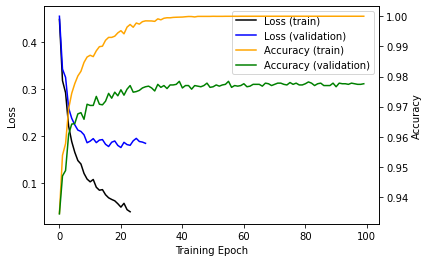

In [8]:
# load mnist data
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX/255.0
testX = testX/255.0

# reshape the data to a vector
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# split test data into validation and test sets
valX, testX, valY, testY = train_test_split(testX, testY, test_size = 0.5)

# create a model
model = FeedforwardNeuralNetwork([784, 64, 32, 10], 0.001, activations = 'ReLU', initialization = ['Glorot', 'normal'], loss = 'cross-entropy')

# fit the model to the training data
model.fit(trainX, trainY, valX, valY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Note the numpy implementation of the logarithm runs into errors sometimes when the predicted y values are very near 0 or very near 1 since this results in the log of a tiny value, which causes an overflow. However, it will be an expression like $y\log y$ with $y\to 0$ or $(1-y)\log(1-y)$ with $y\to 1$, each of which is 0 in the limit.

The best test accuracy occurs with the [784, 64, 10] and [784, 64, 32, 10] networks. They have nearly the same accuracy, so the smaller [784, 64, 10] network would be preferred since it fits and predicts faster.